<a href="https://colab.research.google.com/github/dani-lbnl/mudit/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import packages

In [33]:
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (97.0.4692.71-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import Select
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
import gensim
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pprint

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
def get_driver():
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  options.add_argument("--disable-infobars")
  # open it, go to a website, and get results
  wd = webdriver.Chrome('chromedriver',options=options)
  return wd

### import and process data from pubs.xlsx

In [2]:
def preprocess_lda(data):
  stop_words = stopwords.words('english')

  def remove_stopwords(texts):
      return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  data_words_nostops = remove_stopwords(data)

  # Create Dictionary 
  id2word = corpora.Dictionary(data_words_nostops)  
  # Create Corpus 
  texts = data_words_nostops  
  # Term Document Frequency 
  corpus = [id2word.doc2bow(text) for text in texts]  

  words = []
  for word in texts:
    words.extend(word)

  return corpus, id2word, words

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
df = pd.read_table('/content/drive/MyDrive/LBNL/Pubs.xls')
abstracts = list(df[~df['Abstract'].isna()]['Abstract'])

corpus_abs, id2word_abs, words_abs = preprocess_lda(abstracts)

### Word2Vec model for something

In [ ]:
from gensim.models import KeyedVectors
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('drive/MyDrive/LBNL/GoogleNews-vectors-negative300.bin', binary=True)
# Access vectors for specific words with a keyed lookup:
vector = model['easy']
vector.shape

#### using similarity for something

In [ ]:
def get_sim(num_topics):

  # create lda model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_abs,
                                            id2word=id2word_abs,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1,
                                            #  chunksize=100,
                                            passes=30,
                                            alpha='auto',
                                            per_word_topics=True)

  # initialise similarity list 
  similarity_list = []

  for i in range(num_topics):
    terms_1 = [id2word_abs[term[0]] for term in lda_model.get_topic_terms(i)]
    for j in range(i,num_topics):
      terms_2 = [id2word_abs[term[0]] for term in lda_model.get_topic_terms(j)]
      cs = 0
      count = 0
      # print(terms_1, terms_2)
      for val1 in terms_1:
        for val2 in terms_2:
          # print(val1,val2)
          if(val1 in model and val2 in model):
            count += 1
            cs += cosine_similarity(model[[val1]],model[[val2]])[0][0]
      cs = cs/count
      similarity_list.append(cs)
      # print(count)

  return np.array(similarity_list).mean()

x = range(5,50,5)
topic_sim_num = []

for i in x:
  a = get_sim(i)
  print(a)
  topic_sim_num.append(a)

In [ ]:
plt.plot(x,topic_sim_num)
plt.title("Topic similarity Vs Number of Topics - Abstracts")
plt.xlabel("Number of topics")
plt.ylabel("Topic similarity (Cosine)")

#### Iteration 1 - on just abstract

In [40]:
lda_model_abs = gensim.models.ldamodel.LdaModel(corpus=corpus_abs,
                                           id2word=id2word_abs,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                          #  chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

KeyboardInterrupt: ignored

In [ ]:
for i in range(25):
  terms = lda_model_abs.get_topic_terms(i)
  print([id2word_abs[term[0]] for term in terms])

#### Iteration 2 - on combined title and abstract

In [5]:
# set all nulls to blanks - not sure of the reason?

# for title
indices = df['Title'].isna()
df.loc[indices,'Title'] = ""

# for abstract
indices = df['Abstract'].isna()
df.loc[indices,'Abstract'] = ""

# combined - title + abstract
df['Combined'] = df['Title'] + " " + df['Abstract']
combined = list(df['Combined'])

In [6]:
# lda on combined data (title + abstract)

corpus_comb, id2word_comb, words_comb = preprocess_lda(combined)

lda_model_comb = gensim.models.ldamodel.LdaModel(corpus=corpus_comb,
                                           id2word=id2word_comb,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                          #  chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [8]:
# Print the Keyword in the 25 topics
lda_model_comb.print_topics()
# doc_lda = lda_model_comb[corpus_comb]

[(8,
  '0.016*"magma" + 0.010*"host" + 0.010*"mixing" + 0.009*"data" + 0.008*"dike" + 0.008*"phase" + 0.007*"genes" + 0.007*"latent" + 0.006*"inoculated" + 0.006*"enclaves"'),
 (21,
  '0.019*"bone" + 0.012*"sup" + 0.009*"mass" + 0.009*"mechanical" + 0.008*"trabecular" + 0.007*"tgf" + 0.007*"effects" + 0.006*"properties" + 0.006*"multilayer" + 0.006*"columns"'),
 (6,
  '0.020*"image" + 0.013*"analysis" + 0.012*"area" + 0.011*"using" + 0.011*"algorithm" + 0.009*"data" + 0.009*"algorithms" + 0.008*"study" + 0.008*"estimates" + 0.008*"parallel"'),
 (14,
  '0.010*"crystallization" + 0.009*"pressure" + 0.009*"flowers" + 0.007*"high" + 0.007*"deformation" + 0.007*"stress" + 0.006*"water" + 0.006*"fluid" + 0.006*"measurements" + 0.006*"preferred"'),
 (22,
  '0.035*"bone" + 0.016*"fracture" + 0.012*"mode" + 0.012*"cortical" + 0.010*"mechanical" + 0.010*"materials" + 0.010*"toughness" + 0.007*"osteogenesis" + 0.007*"imperfecta" + 0.006*"collagen"'),
 (5,
  '0.015*"textile" + 0.011*"data" + 0.011

In [ ]:
# print words 

for i in range(25):
  terms = lda_model_comb.get_topic_terms(i)
  print(terms)
  print([id2word_comb[term[0]] for term in terms])

#### Analyzing LDA model results

In [9]:
!pip install pyLDAvis

In [10]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
# LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(25))

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_comb, corpus_comb, id2word_comb)
LDAvis_prepared

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_comb, corpus_comb, id2word_comb)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(25) +'.html')
# LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.146917 -0.023422       1        1  7.938132
20    -0.010170  0.073208       2        1  7.659150
24    -0.083795  0.125480       3        1  7.315985
0     -0.006039  0.158535       4        1  6.670991
1      0.087392  0.064251       5        1  5.699844
17    -0.060092  0.021422       6        1  5.405043
4      0.092302  0.048521       7        1  5.296056
9      0.196777  0.016308       8        1  5.229302
7      0.010341  0.046625       9        1  4.858647
15    -0.002268  0.056168      10        1  4.436713
13    -0.037134  0.107324      11        1  3.942777
23    -0.061464  0.043770      12        1  3.483504
19    -0.017505  0.038863      13        1  3.457129
2     -0.060885 -0.047164      14        1  3.207343
3     -0.018355 -0.059739      15        1  3.154457
18     0.161532 -0.010322      16        1  2.892414
12    -0.077530 -0.077366      17        1  2.788499
5     -0.007453 -0.061033      18        1  2.580420
11     0.034203 -0.043732      19        1  2.559514
6     -0.008888 -0.035950      20        1  2.252460
16    -0.025861  0.022513      21        1  2.132010
14     0.097009 -0.050954      22        1  1.975160
21    -0.060297 -0.109739      23        1  1.961296
22    -0.110557 -0.133506      24        1  1.577426
8      0.115653 -0.170060      25        1  1.525728, topic_info=          Term        Freq       Total Category  logprob  loglift
16        bone  215.000000  215.000000  Default  30.0000  30.0000
3515   lithium   96.000000   96.000000  Default  29.0000  29.0000
846        inf  189.000000  189.000000  Default  28.0000  28.0000
48    fracture   98.000000   98.000000  Default  27.0000  27.0000
1532    vessel   56.000000   56.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1519    plants    2.797076   29.455280  Topic25  -5.3282   1.8284
382     pumice    2.797186   44.180995  Topic25  -5.3281   1.4230
133        one    2.605819   42.018908  Topic25  -5.3990   1.4023
739   analysis    2.229599   91.018830  Topic25  -5.5549   0.4735
2938    leaves    2.104825   14.336261  Topic25  -5.6125   2.2641

[1629 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2178     16  0.739561     ablator
4940      2  0.884344   absorbent
5049     15  0.726367   absorbers
1858      1  0.118269  absorption
1858      2  0.709612  absorption
...     ...       ...         ...
715      14  0.284817          μm
715      17  0.040688          μm
715      18  0.040688          μm
715      19  0.081376          μm
715      20  0.040688          μm

[4497 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 21, 25, 1, 2, 18, 5, 10, 8, 16, 14, 24, 20, 3, 4, 19, 13, 6, 12, 7, 17, 15, 22, 23, 9])

##### Wordcloud by each topic

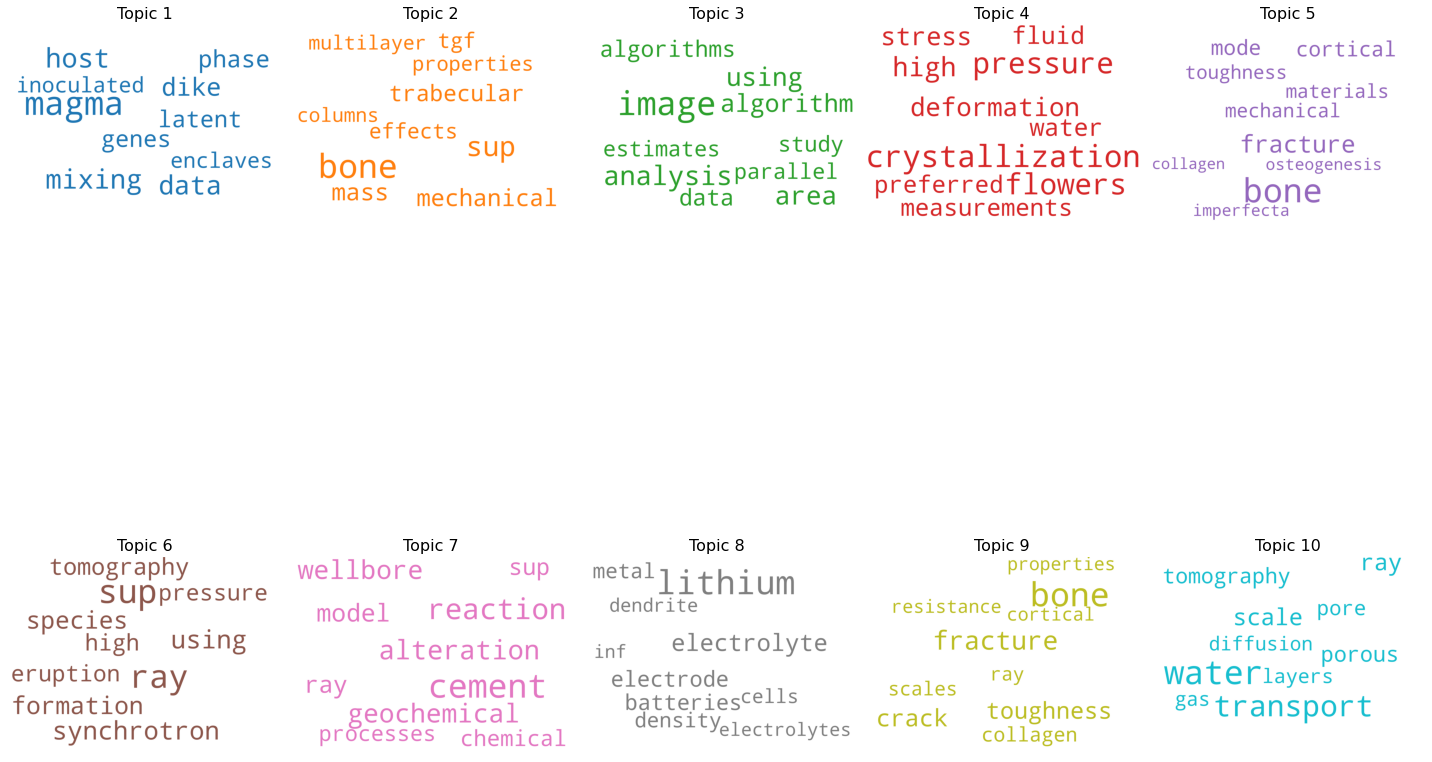

In [27]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_comb.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [30]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model_comb[corpus_comb]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 25
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will no

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 438 samples in 0.001s...
[t-SNE] Computed neighbors for 438 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 438 / 438
[t-SNE] Mean sigma: 0.000458
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.158745
[t-SNE] KL divergence after 1000 iterations: 0.134277


##### 10 topics combined

In [ ]:
lda_model_comb_10 = gensim.models.ldamodel.LdaModel(corpus=corpus_comb,
                                           id2word=id2word_comb,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           alpha='auto',
                                           passes = 30,
                                           per_word_topics=True)

In [41]:
# Print the Keyword in the 25 topics
lda_model_comb_10.print_topics()

[(0,
  '0.016*"water" + 0.012*"transport" + 0.012*"ray" + 0.010*"tomography" + 0.008*"computed" + 0.007*"fuel" + 0.007*"catalyst" + 0.007*"cells" + 0.006*"scale" + 0.006*"polymer"'),
 (1,
  '0.008*"data" + 0.007*"ray" + 0.007*"inf" + 0.006*"model" + 0.006*"carbonate" + 0.006*"tomography" + 0.006*"experiments" + 0.006*"cement" + 0.006*"reactive" + 0.006*"pore"'),
 (2,
  '0.020*"bone" + 0.012*"scaffolds" + 0.006*"strength" + 0.006*"glass" + 0.005*"mechanical" + 0.005*"properties" + 0.005*"phase" + 0.005*"high" + 0.005*"inf" + 0.005*"defects"'),
 (3,
  '0.032*"bone" + 0.018*"fracture" + 0.012*"toughness" + 0.011*"crack" + 0.009*"properties" + 0.007*"cortical" + 0.006*"human" + 0.006*"scales" + 0.006*"ray" + 0.005*"resistance"'),
 (4,
  '0.018*"sup" + 0.013*"ray" + 0.007*"using" + 0.007*"high" + 0.006*"synchrotron" + 0.006*"tomography" + 0.005*"pore" + 0.005*"new" + 0.005*"inf" + 0.005*"micro"'),
 (5,
  '0.009*"mechanical" + 0.007*"energy" + 0.006*"properties" + 0.006*"structure" + 0.005*"

In [42]:

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_comb_10, corpus_comb, id2word_comb)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.008240  0.074702       1        1  14.805301
3     -0.165247 -0.073939       2        1  13.031944
9      0.155752 -0.139171       3        1  11.098908
4      0.073042  0.002174       4        1  10.915517
1      0.058066  0.071453       5        1  10.439325
6     -0.005567  0.087358       6        1   9.484041
5     -0.090163  0.005736       7        1   9.215038
0      0.019742  0.122440       8        1   9.030353
2     -0.100727 -0.069012       9        1   8.414229
8      0.046862 -0.081741      10        1   3.565345, topic_info=           Term        Freq       Total Category  logprob  loglift
16         bone  220.000000  220.000000  Default  30.0000  30.0000
3515    lithium   94.000000   94.000000  Default  29.0000  29.0000
1539      xylem   90.000000   90.000000  Default  28.0000  28.0000
48     fracture  100.000000  100.000000  Default  27.0000  27.0000
224         sup  147.000000  147.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
117        high    4.695168  152.909397  Topic10  -5.6590  -0.1494
1445     damage    3.433363   24.504886  Topic10  -5.9720   1.3686
320         two    3.799293   65.945149  Topic10  -5.8707   0.4799
1014    network    3.433373   31.057980  Topic10  -5.9720   1.1316
759   diffusion    3.433270   35.662798  Topic10  -5.9720   0.9933

[683 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4430      6  0.893950    ablative
2178      4  0.935514     ablator
4940      7  0.949111   absorbent
1858      2  0.063102  absorption
1858      6  0.063102  absorption
...     ...       ...         ...
1371      4  0.600740       yield
1371     10  0.133498       yield
6208      8  0.851346     zoobank
5644      1  0.223206          zr
5644      9  0.744020          zr

[1676 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 10, 5, 2, 7, 6, 1, 3, 9])

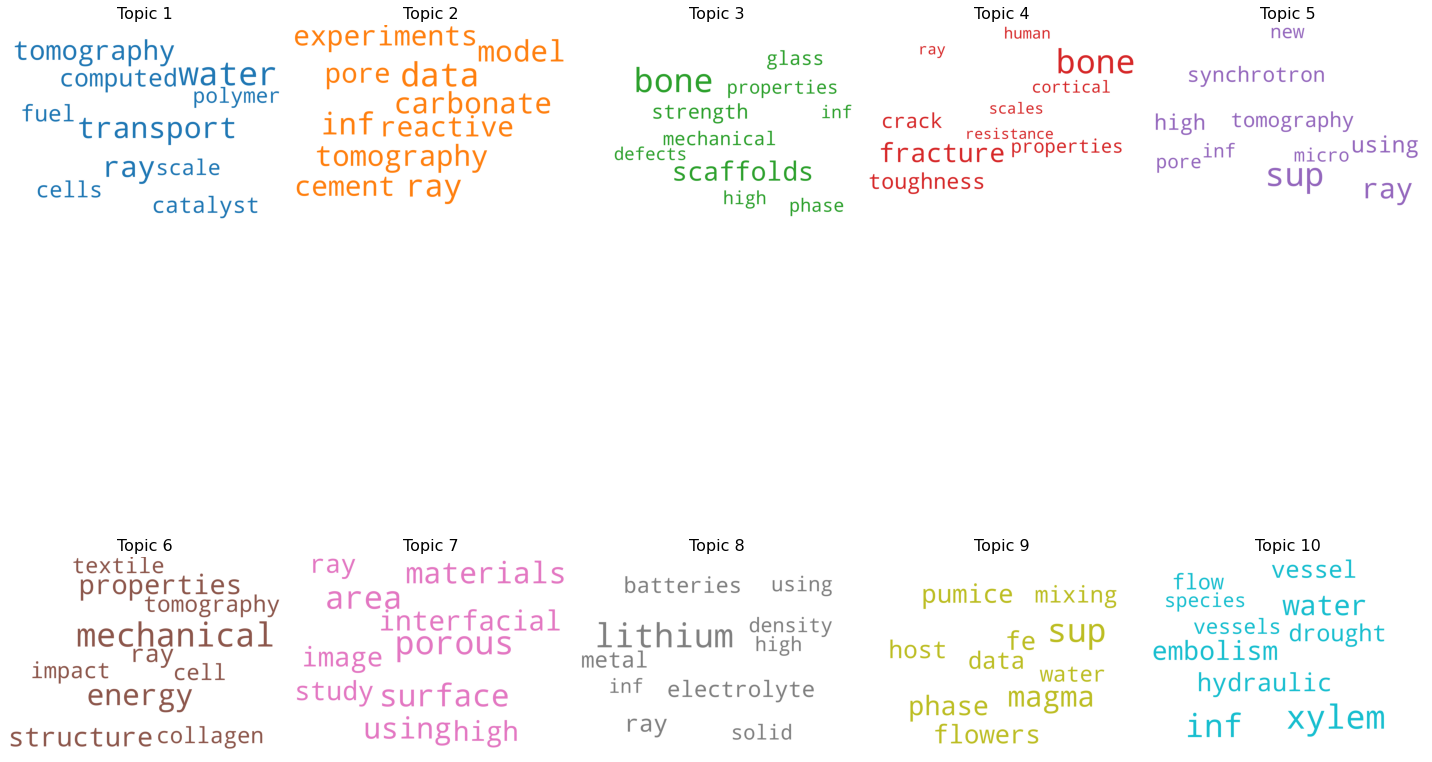

In [43]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_comb_10.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()